In [66]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
from h5py import File
from astropy.coordinates import SkyCoord
import astropy.units as u

import candel
from candel import SPEED_OF_LIGHT

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def mean_sky_position(ra_deg, dec_deg):
    """
    Compute the mean sky position (RA, Dec) on the celestial sphere.
    """
    ra = np.deg2rad(ra_deg)
    dec = np.deg2rad(dec_deg)

    x = np.cos(dec) * np.cos(ra)
    y = np.cos(dec) * np.sin(ra)
    z = np.sin(dec)

    x_mean = np.mean(x)
    y_mean = np.mean(y)
    z_mean = np.mean(z)

    r = np.sqrt(x_mean**2 + y_mean**2 + z_mean**2)
    dec_mean = np.arcsin(z_mean / r)
    ra_mean = np.arctan2(y_mean, x_mean) % (2 * np.pi)

    return np.rad2deg(ra_mean), np.rad2deg(dec_mean)



def load_cepheid_table(filename):
    """Load Cepheid data from a LaTeX deluxetable."""
    data = []
    with open(filename, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("\\") or "colhead" in line:
                continue

            parts = [entry.strip().rstrip("\\") for entry in line.split("&")]

            if len(parts) != 11:
                continue

            try:
                row = (
                    str(parts[0]),
                    float(parts[1]),
                    float(parts[2]),
                    int(parts[3]),
                    float(parts[4]),
                    float(parts[5]),
                    float(parts[6]),
                    float(parts[7]),
                    float(parts[8]),
                    float(parts[9]),
                    str(parts[10])
                )
                data.append(row)
            except ValueError:
                continue  # skip malformed rows

    dtype = np.dtype([
        ("Field", "U10"),
        ("RA_J2000", "f8"),
        ("Dec_J2000", "f8"),
        ("Id", "i8"),
        ("P_days", "f8"),
        ("F555W_minus_F814W", "f8"),
        ("sigma_color", "f8"),
        ("F160W", "f8"),
        ("sigma_F160W", "f8"),
        ("OH", "f8"),
        ("Note", "U10")
    ])

    return np.array(data, dtype=dtype)


def compute_mean_galaxy_positions(arr):
    """
    Compute the mean sky position (RA, Dec) for each unique galaxy in a
    structured array.
    """
    galaxies = np.unique(arr["Field"])
    rows = []

    for name in galaxies:
        m = arr["Field"] == name
        ra = arr["RA_J2000"][m]
        dec = arr["Dec_J2000"][m]

        if len(ra) == 0:
            continue

        ra_mean, dec_mean = mean_sky_position(ra, dec)
        rows.append((name, ra_mean, dec_mean))

    dtype = np.dtype([
        ("Field", "U16"),
        ("RA_J2000", "f8"),
        ("Dec_J2000", "f8")
    ])

    return np.array(rows, dtype=dtype)


def crossmatch_galaxies_to_catalog(mean_pos_arr, ra_catalog, dec_catalog):
    """
    Cross-match galaxy positions to a catalog of sources.

    Parameters
    ----------
    mean_pos_arr : structured array
        Must contain "RA_J2000" and "Dec_J2000" fields (in degrees).
    ra_catalog : array_like
        RA values of catalog sources (in degrees).
    dec_catalog : array_like
        Dec values of catalog sources (in degrees).

    Returns
    -------
    idx : ndarray of int
        Indices into the catalog (ra_catalog/dec_catalog) corresponding to the
        closest match for each galaxy in mean_pos_arr.
    sep_arcsec : ndarray of float
        Angular separations to matched sources (in arcseconds).
    """
    gal_coords = SkyCoord(ra=mean_pos_arr["RA_J2000"] * u.deg,
                          dec=mean_pos_arr["Dec_J2000"] * u.deg)
    cat_coords = SkyCoord(ra=ra_catalog * u.deg, dec=dec_catalog * u.deg)

    idx, sep2d, _ = gal_coords.match_to_catalog_sky(cat_coords)
    return idx, sep2d.arcsec

In [3]:
# Load the SH0ES Cepheid table and Pantheon+ data
data_cepheid = load_cepheid_table("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/table2.tex")
data_pantheonplus = np.genfromtxt("/Users/rstiskalek/Projects/CANDEL/data/Pantheon+/Pantheon+SH0ES.dat", names=True, delimiter=" ", )

# Compute the sky position of the galaxies hosting Cepheids
galaxy_pos = compute_mean_galaxy_positions(data_cepheid)

# Crossmatch the anchors to the Pantheon+ catalog
ks, dtheta = crossmatch_galaxies_to_catalog(galaxy_pos, data_pantheonplus["RA"], data_pantheonplus["DEC"])

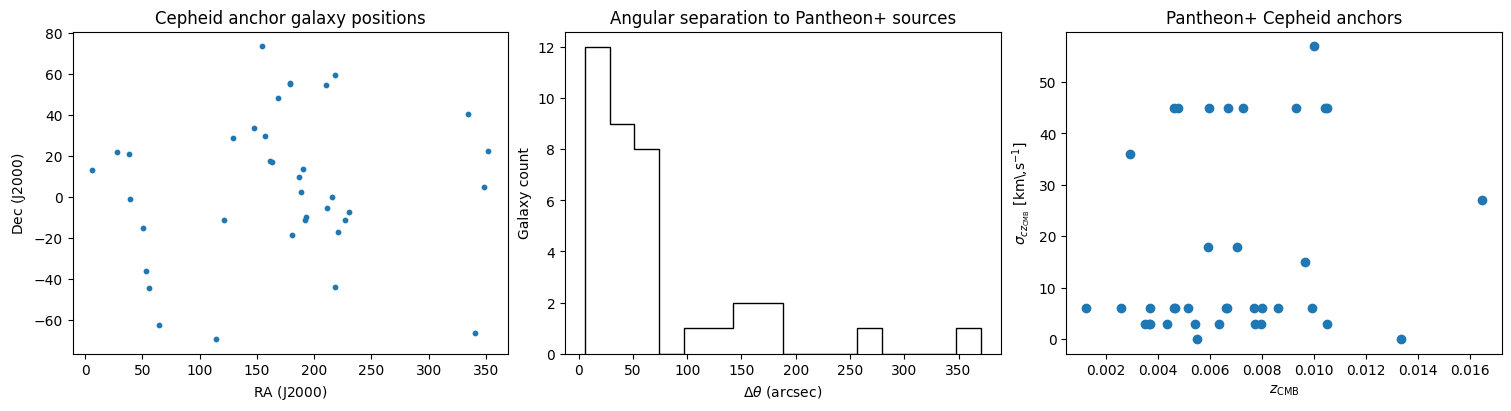

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

# Panel 1: Galaxy positions
axes[0].set_title(r"Cepheid anchor galaxy positions")
axes[0].scatter(galaxy_pos["RA_J2000"], galaxy_pos["Dec_J2000"], s=10)
axes[0].set_xlabel(r"$\mathrm{RA}\ (\mathrm{J2000})$")
axes[0].set_ylabel(r"$\mathrm{Dec}\ (\mathrm{J2000})$")

# Panel 2: Angular separations
axes[1].hist(dtheta, bins="auto", histtype="step", color="k")
axes[1].set_xlabel(r"$\Delta \theta$ (arcsec)")
axes[1].set_ylabel(r"Galaxy count")
axes[1].set_title(r"Angular separation to Pantheon+ sources")

# Panel 3: Pantheon+ redshift uncertainties
axes[2].set_title(r"Pantheon+ Cepheid anchors")
axes[2].scatter(data_pantheonplus["zCMB"][ks],
                data_pantheonplus["zCMBERR"][ks] * SPEED_OF_LIGHT)
axes[2].set_xlabel(r"$z_{\rm CMB}$")
axes[2].set_ylabel(r"$\sigma_{cz_{\rm CMB}}$ [km\,s$^{-1}$]")

plt.show()

In [25]:
output_file = "/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_PantheonPlus_match.hdf5"
with File(output_file, "w") as f:
    # Save galaxy positions
    f.create_dataset("galaxy_pos/Field", data=np.array(galaxy_pos["Field"], dtype="S"))
    f.create_dataset("galaxy_pos/RA_J2000", data=galaxy_pos["RA_J2000"])
    f.create_dataset("galaxy_pos/Dec_J2000", data=galaxy_pos["Dec_J2000"])

    # Save matched Pantheon+ entries (structured array)
    grp = f.create_group("pantheonplus")
    for name in data_pantheonplus[ks].dtype.names:
        data = data_pantheonplus[ks][name]
        # Convert strings to fixed-length bytes if necessary
        if data.dtype.kind in {"U", "S"}:
            data = np.array(data, dtype="S")
        grp.create_dataset(name, data=data)

print(f"Matches saved to {output_file}")

Matches saved to /Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_PantheonPlus_match.hdf5


In [68]:
def match_qnames_to_redshifts(h5_path="/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_PantheonPlus_match.hdf5",
                               shoes_data_path="/Users/rstiskalek/Projects/CANDEL/data/SH0ES"):
    """
    Match SH0ES q_names to galaxy redshifts and uncertainties from the Pantheon+ anchor file.
    """
    # Load SH0ES q_names
    data = candel.pvdata.load_SH0ES_separated(shoes_data_path)
    q_names = np.array(data["q_names"]).astype(str)

    # Load Pantheon+ redshift info
    with File(h5_path, 'r') as f:
        galaxy_names = f["galaxy_pos/Field"][...].astype(str)
        zcmb = f["pantheonplus/zCMB"][...]
        zcmb_err = f["pantheonplus/zCMBERR"][...] * SPEED_OF_LIGHT

    # Extract base names and apply manual fixes
    gal_names_from_q = np.char.replace(q_names, "mu_", "")
    gal_names_from_q[gal_names_from_q == "N0105"] = "N105A"
    gal_names_from_q[gal_names_from_q == "N0976"] = "N976A"

    # Perform matching
    common, i_q, i_gal = np.intersect1d(gal_names_from_q, galaxy_names, return_indices=True)

    # Prepare output arrays
    zcmb_matched = np.full(q_names.shape, np.nan)
    czcmb_err_matched = np.full(q_names.shape, np.nan)

    # Assign values
    zcmb_matched[i_q] = zcmb[i_gal]
    czcmb_err_matched[i_q] = zcmb_err[i_gal]

    # Report unmatched (optional)
    unmatched = q_names[~np.isin(np.arange(len(q_names)), i_q)]
    if unmatched.size > 0:
        print("Still unmatched:")
        print(unmatched)

    return q_names, zcmb_matched, czcmb_err_matched

In [75]:
q_names, zcmb_matched, czcmb_err_matched = match_qnames_to_redshifts()

assert np.isfinite(zcmb_matched).sum() == 37

2025-06-07 15:35:17 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-07 15:35:17 indices of zero width: [44]
2025-06-07 15:35:17 found zero-width prior at index 44. Setting it to 0.
Still unmatched:
['Delta_mu_N4258' 'M_H1_W' 'Delta_mu_LMC' 'mu_M31' 'b_W' 'MB0' 'Z_W'
 'undefined' 'Delta_zp' 'log10_H0']


In [83]:
m = np.isfinite(zcmb_matched)

filename_out = "/Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_redshifts.txt"
np.savetxt(filename_out,
           np.column_stack([np.char.replace(q_names[np.isfinite(zcmb_matched)], "mu_", "").astype(object),
                            zcmb_matched[np.isfinite(zcmb_matched)],
                            czcmb_err_matched[np.isfinite(zcmb_matched)]]),
           fmt=["%s", "%.6f", "%.1f"],
           header="Galaxy z_CMB e_cz_CMB", comments='')
print(f"Redshifts saved to {filename_out}")

Redshifts saved to /Users/rstiskalek/Projects/CANDEL/data/SH0ES/processed/Cepheid_anchors_redshifts.txt
